# Creación de modelos

En este notebook vamos a implementar diferentes modelos para el sistema TEP. Cada uno de los modelos tiene un objetivo específico. Los objetivos que vamos a plantear son: detectar fallos presentes, anticipar fallos futuros, clasificar el tipo de fallo y detectar anomalías usando enfoques no supervisados.

Durante el notebook hemos detallado el proceso de creación de los modelos y tambien la evaluación de cada modelo mediante algunas métricas como recall, precisión y F1-score.

In [1]:
!pip install bentoml==1.4.12

import os
import joblib
import pandas as pd
import bentoml
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score

## Selección de variables

Vamos a realizar un analisis para seleccionar el número de varaibles optimo para entrenar nuestros modelos, ya que usar todas es demasiado costoso. Para ello, hemos decidido escoger aquellas con un 75%.

Calculando importancia de variables...


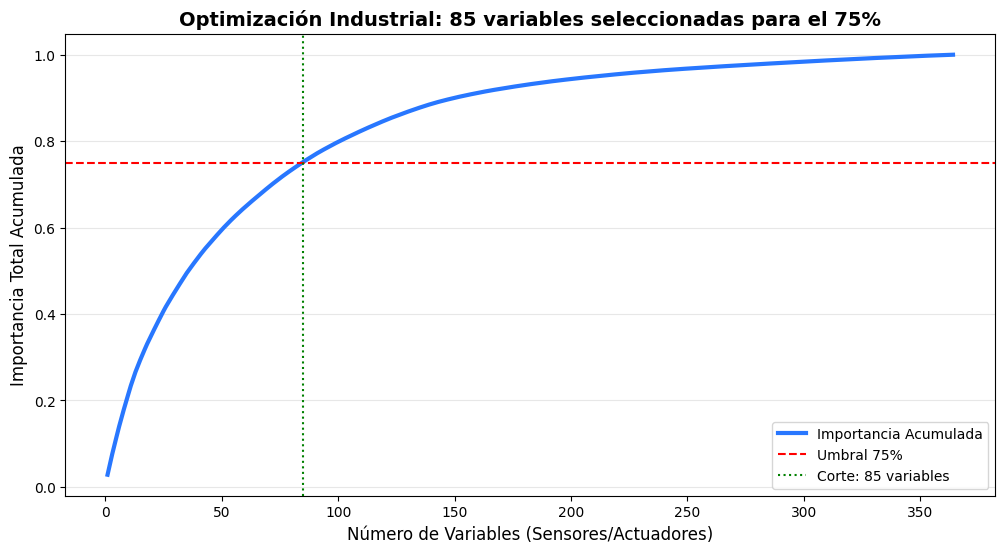

--- CONCLUSIÓN DE OPTIMIZACIÓN ---
Variables totales disponibles: 364
Variables seleccionadas (75% importancia): 85
Reducción de dimensionalidad: 76.65%


In [2]:
# ==============================================================================
# SELECCIÓN DINÁMICA DE VARIABLES 
# ==============================================================================

# 1. CARGA DE DATOS PARA MODELADO
df_model = pd.read_csv("DatasetProcesado/TEP_features_train.csv")

# Definir columnas que NO son predictoras
cols_no_deseadas = [
    'faultNumber', 'simulationRun', 'sample', 
    'fault_present', 'time_since_fault', 'fault_stage'
]

feature_columns = [c for c in df_model.columns if c not in cols_no_deseadas]

X = df_model[feature_columns]
y = df_model['fault_present']

# División entrenamiento/test inicial
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. ANÁLISIS DE IMPORTANCIA ACUMULADA
print("Calculando importancia de variables...")
clf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf_selector.fit(X_train, y_train)

# Calcular importancia y ordenarla
importancias = pd.Series(clf_selector.feature_importances_, index=feature_columns).sort_values(ascending=False)
importancia_acumulada = importancias.cumsum()

# 3. SELECCIÓN AUTOMÁTICA SEGÚN UMBRAL (75%)
umbral_target = 0.75
n_optimo = (importancia_acumulada < umbral_target).sum() + 1
top_features = importancias.head(n_optimo).index.tolist()

# 4. VISUALIZACIÓN DEL CRITERIO DE OPTIMIZACIÓN
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(importancias) + 1), importancia_acumulada, color='#2877FF', linewidth=3, label='Importancia Acumulada')
plt.axhline(y=umbral_target, color='r', linestyle='--', label=f'Umbral {int(umbral_target*100)}%')
plt.axvline(x=n_optimo, color='g', linestyle=':', label=f'Corte: {n_optimo} variables')

plt.title(f'Optimización Industrial: {n_optimo} variables seleccionadas para el {int(umbral_target*100)}%', fontsize=14, fontweight='bold')
plt.xlabel('Número de Variables (Sensores/Actuadores)', fontsize=12)
plt.ylabel('Importancia Total Acumulada', fontsize=12)
plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)
plt.show()

print(f"--- CONCLUSIÓN DE OPTIMIZACIÓN ---")
print(f"Variables totales disponibles: {len(feature_columns)}")
print(f"Variables seleccionadas (75% importancia): {n_optimo}")
print(f"Reducción de dimensionalidad: {((len(feature_columns)-n_optimo)/len(feature_columns))*100:.2f}%")

In [3]:
import joblib
import json

# Guardar como JSON
with open("DatasetProcesado/top_features.json", "w") as f:
    json.dump(top_features, f)

joblib.dump(top_features, "DatasetProcesado/top_features.pkl")

print(f"Lista de {len(top_features)} variables guardada correctamente.")

Lista de 85 variables guardada correctamente.


# Modelo 1: Clasificación binaria

## Objetivo del modelo

El objetivo de este primer modelo implementado es clasificar cada simulacro del dataset TEP como:
- 0 → No ocurrió ningún fallo
- 1 → Ocurrió un fallo
Es decir que se busca detectar si ya ha ocurrido un fallo basándose en las mediciones y variables de control de cada simulacro.

In [4]:
def entrenar_modelo1():
    # 1. Cargar datasets (Entrenamiento y Test independiente)
    df_train = pd.read_csv("DatasetProcesado/TEP_features_train.csv")
    df_test_real = pd.read_csv("DatasetProcesado/TEP_features_test.csv")
    target_col = 'fault_present'

    # 2. Selección de variables optimizadas (top_features ya debe existir en tu sesión)
    X_train_full = df_train[top_features]
    y_train_full = df_train[target_col]
    X_test_real = df_test_real[top_features]
    y_test_real = df_test_real[target_col]

    # 3. Escalado Profesional (Fit solo en Train)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_full)
    X_test_scaled = scaler.transform(X_test_real) # Transformación limpia en Test

    # 4. Entrenamiento del Modelo (Optimizado: 60 árboles para ligereza)
    clf = RandomForestClassifier(
        n_estimators=60, 
        max_depth=12, 
        random_state=42, 
        n_jobs=-1
    )
    
    print("Entrenando Modelo 1 (Binario)...")
    clf.fit(X_train_scaled, y_train_full)

    # 5. Generar ranking de importancia
    ranking = pd.DataFrame({
        'feature': top_features,
        'importance': clf.feature_importances_
    }).sort_values(by='importance', ascending=False)

    os.makedirs("modelos", exist_ok=True)
    ranking.to_csv("modelos/feature_importance_ranking_model1.csv", index=False)

    # 6. Registro en BentoML con metadatos para el servicio
    bentoml.sklearn.save_model(
        "tep_model1",
        clf,
        metadata={
            "top_features": top_features,
            "scaler_mean": scaler.mean_.tolist(),
            "scaler_scale": scaler.scale_.tolist(),
            "n_features": len(top_features),
            "threshold": "75% importance",
            "trained_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
    )

    # 7. Evaluación
    y_pred = clf.predict(X_test_scaled)
    y_proba = clf.predict_proba(X_test_scaled)[:, 1]
    
    metrics = {
        'accuracy': accuracy_score(y_test_real, y_pred),
        'precision': precision_score(y_test_real, y_pred, average='weighted'),
        'recall': recall_score(y_test_real, y_pred, average='weighted'),
        'f1_score': f1_score(y_test_real, y_pred, average='weighted'),
        'roc_auc': roc_auc_score(y_test_real, y_proba),
        'confusion_matrix': confusion_matrix(y_test_real, y_pred),
        'classification_report': classification_report(y_test_real, y_pred, digits=4)
    }

    return clf, ranking, metrics, X_test_scaled, y_test_real

### Evaluación del modelo
Por último, para evaluar los resultados del modelo, se han implementado 3 métricas: Confusión matrix, classification report y ROC-AUC Score

In [5]:
# Ejecución
clf, ranking, metrics, X_test, y_test = entrenar_modelo1()

# Visualización de resultados
print("=== RESULTADOS MODELO 1 (BINARIO) ===")
print("Confusion Matrix:")
print(metrics["confusion_matrix"])

print(f"\nAccuracy:  {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall:    {metrics['recall']:.4f}")
print(f"F1-score:  {metrics['f1_score']:.4f}")
print(f"ROC-AUC:   {metrics['roc_auc']:.4f}")

print("\nClassification Report:")
print(metrics["classification_report"])

Entrenando Modelo 1 (Binario)...
=== RESULTADOS MODELO 1 (BINARIO) ===
Confusion Matrix:
[[ 18060   1140]
 [   599 191401]]

Accuracy:  0.9918
Precision: 0.9917
Recall:    0.9918
F1-score:  0.9917
ROC-AUC:   0.9992

Classification Report:
              precision    recall  f1-score   support

           0     0.9679    0.9406    0.9541     19200
           1     0.9941    0.9969    0.9955    192000

    accuracy                         0.9918    211200
   macro avg     0.9810    0.9688    0.9748    211200
weighted avg     0.9917    0.9918    0.9917    211200



Como muestra la matriz de confusión, hay un desequilibrio en la proporción del dataset: la clase 1 (fallo) tiene 192,000 muestras, mientras que la clase Normal (0) cuenta con 19,200 muestras. Esto es un desequilibrio de 10:1. Cabe aclarar que este desequilibrio no es un error en la reducción, sino una decisión intencionada con el fin de respetar la proporción del dataset original.

### Conclusión

Por lo que muestran las metricas, la exactitud obtenida es del 99.18%, lo que indica que el modelo distingue casi perfectamente simulacros con fallo de los que no tienen fallo. A pesar de lo mencionado del desequilibrio entre clases, el modelo es casi perfecto detectando correctamente el 99.69% de los fallos (solo 599 falsos negativos) y el 94.06% de los estados normales (1140 falsos positivos).

Como conclusión sobre el desempeño, se puede afirmar que el modelo está cumpliendo el objetivo inicial: identificar si ha ocurrido un fallo en cada simulación.

# Modelo 2: Predicción de fallos

## Objetivo del modelo

El objetivo de este modelo es predecir si ocurrirá un fallo en el sistema TEP en los próximos HORIZON pasos. Esto permite anticipar posibles problemas y actuar antes de que se produzcan, funcionando como un sistema de alerta temprana.

### Preparación de los datos

Lo primero es cargar los datasets, archivos predefinidos de entrenamiento y prueba para respetar la separación temporal.

In [27]:
def entrenar_modelo2():
    # 1. Cargar datasets independientes
    df_train_full = pd.read_csv("DatasetProcesado/TEP_features_train.csv")
    df_test_real = pd.read_csv("DatasetProcesado/TEP_features_test.csv")
    target_col = 'fault_present'

    # 2. MUESTREO ESTRATIFICADO (30% para salvar RAM)
    df_train, _ = train_test_split(
        df_train_full, 
        train_size=0.3, 
        stratify=df_train_full[target_col], 
        random_state=42
    )
    
    # 3. Preparación de datos en float32
    X_train = df_train[top_features].astype(np.float32)
    y_train = df_train[target_col]
    X_test_real = df_test_real[top_features].astype(np.float32)
    y_test_real = df_test_real[target_col]

    # 4. Escalado
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test_real)

    # 5. Entrenamiento Ligero (n_jobs=1 para evitar MemoryError)
    clf = RandomForestClassifier(
        n_estimators=50, 
        max_depth=10,
        class_weight='balanced', 
        random_state=42, 
        n_jobs=1 
    )
    
    print(f"Entrenando Modelo 2 con {len(X_train)} filas...")
    clf.fit(X_train_scaled, y_train)

    # 6. Importancia de variables
    ranking = pd.DataFrame({
        'feature': top_features,
        'importance': clf.feature_importances_
    }).sort_values(by='importance', ascending=False)

    
    ranking.to_csv("modelos/feature_importance_ranking_model2.csv", index=False)

    # 7. Registro en BentoML
    bentoml.sklearn.save_model(
        "tep_model2",
        clf,
        metadata={
            "top_features": top_features,
            "scaler_mean": scaler.mean_.tolist(),
            "scaler_scale": scaler.scale_.tolist(),
            "n_features": len(top_features)
        }
    )

    # 8. Métricas
    y_pred = clf.predict(X_test_scaled)
    metrics = {
        'accuracy': accuracy_score(y_test_real, y_pred),
        'precision': precision_score(y_test_real, y_pred, average='weighted'),
        'recall': recall_score(y_test_real, y_pred, average='weighted'),
        'f1_score': f1_score(y_test_real, y_pred, average='weighted'),
        'confusion_matrix': confusion_matrix(y_test_real, y_pred),
        'classification_report': classification_report(y_test_real, y_pred, digits=4)
    }

    return clf, ranking, metrics, X_test_scaled, y_test_real

### Selección del modelo
El modelo elegido es Random Forest por su robustez ante datasets con muchas variables y su capacidad de manejar relaciones no lineales. Hay 2 variables que vale la pena mencionar/explicar.
- n_estimators=100 para estabilidad en la predicción.
- class_weight='balanced' corrige el desbalance natural de fallos vs no-fallos.

### Evaluación del modelo
Para evaluar el modelo se usan tres métricas (confusion matrix, classification report y ROC-AUC) por diferentes motivos.
- Confusion Matrix: muestra TP, TN, FP y FN, permitiendo ver la exactitud de predicción de fallos y no-fallos.
- Classification Report: muestra precisión, recall y f1-score; el recall es especialmente importante para fallos (evitar no detectar fallos).
- ROC-AUC: evalúa la capacidad del modelo de separar correctamente las clases, robusto frente al desbalance.

In [28]:
# Ejecución
clf2, ranking2, metrics2, X_test2, y_test2 = entrenar_modelo2()

print("=== RESULTADOS MODELO 2 (HORIZONTE) ===")
print("Confusion Matrix:")
print(metrics2["confusion_matrix"])

print(f"\nAccuracy:  {metrics2['accuracy']:.4f}")
print(f"Precision: {metrics2['precision']:.4f}")
print(f"Recall:    {metrics2['recall']:.4f}")
print(f"F1-score:  {metrics2['f1_score']:.4f}")

print("\nClassification Report:")
print(metrics2["classification_report"])

Entrenando Modelo 2 con 33000 filas...
=== RESULTADOS MODELO 2 (HORIZONTE) ===
Confusion Matrix:
[[ 18658    542]
 [  4420 187580]]

Accuracy:  0.9765
Precision: 0.9800
Recall:    0.9765
F1-score:  0.9775

Classification Report:
              precision    recall  f1-score   support

           0     0.8085    0.9718    0.8826     19200
           1     0.9971    0.9770    0.9869    192000

    accuracy                         0.9765    211200
   macro avg     0.9028    0.9744    0.9348    211200
weighted avg     0.9800    0.9765    0.9775    211200



## Conclusiones 

Como desempeño general, se puede confirmar que la exactitud global es muy alta (97.65%), lo que indica que el modelo clasifica correctamente la gran mayoría de los registros. Sin embargo, la exactitud por sí sola puede ser engañosa debido al desbalance de clases (1:10, fallos vs no-fallos).

En cuanto a la matriz de confusión se puede interpretar por los resultados, que se detectan claramente los fallos y no fallos de la siguiente manera:
- Clase 0 (no fallo): 542 falsos positivos (predijo fallo cuando no hubo).
- Clase 1 (fallo): solo 4,420 falsos negativos (fallos no detectados), lo que indica que el modelo casi siempre anticipa los fallos correctamente.

El classification report, por su parte diferencia los siguientes indicadores clave para cada clase: 
- Recall de fallos (1): 0.9770 → el modelo detecta casi el 98% de los fallos, lo cual es crítico para un sistema de alerta temprana.
- Recall de no-fallos (0):0.9718 → el modelo identifica correctamente el 97% de los estados normales, demostrando que la técnica de class_weight='balanced' ha funcionado para no ignorar la clase minoritaria.
- F1-score: el equilibrio para la clase mayoritaria es excelente (0.9869). Para la clase normal, el F1-Score es de 0.8826, un valor muy sólido dado que es la clase con 10 veces menos representación.

Con todo ello, se puede concluir que el modelo es confiable para anticipar fallos y puede ser utilizado sistemas de mantenimiento predictivo. La decisión de usar class_weight='balanced' y Random Forest junto a un muestreo del 30% ha sido acertada para manejar el desbalance y capturar la complejidad del sistema.

# Modelo 3: Clasificación multiclase de fallos

## Objetivo del modelo

Vamos a crear este modelo para predecir el tipo de fallo que aparece en el TEP, teniendo en cuenta las mediciones de los sensores (variables xmeans), los actuadores (xmv) y las correspondientes variables escaladas.

A diferencia del primer modelo creado, este es un modelo multiclase de 21 clases en el que:

    Clase 0 --> Proceso sin fallo
    Clases 1-20 --> Son los tipos específicos de fallos del proceso

Este modelo es muy útil para realizar un mantenimiento predictivo, ya que a parte de detectar si hay un problema, indica tambien qué tipo de fallo especifico es el que esta ocurriendo. 

### Preparación de los datos

Los dataset que vamos a utilizar son TEP_features_train.cvs y TEP_features_test.csv

Estos dataset tienen las señales originales del proceso (xmeans), las señales de actuación (xmv), señales escaladas, información temporal (simulationRun, sample) y etiquetas sobre el tipo de fallo (faultNumber).

In [23]:
df_train = pd.read_csv("DatasetProcesado/TEP_features_train.csv")
df_test  = pd.read_csv("DatasetProcesado/TEP_features_test.csv")

Comprobamos las primeras filas de los datasets.

In [25]:
# Revisar tamaño y primeras filas
print("Tamaño df_train:", df_train.shape)
print("Primeras filas df_train:")
print(df_train.head())

print("\nTamaño df_test:", df_test.shape)
print("Primeras filas df_test:")
print(df_test.head())

Tamaño df_train: (110000, 370)
Primeras filas df_train:
   faultNumber  simulationRun  sample  xmeas_1  xmeas_2  xmeas_3  xmeas_4  \
0          0.0           10.0       1  0.25125   3671.5   4498.3   9.3137   
1          0.0           10.0       2  0.25068   3661.1   4533.6   9.2646   
2          0.0           10.0       3  0.24835   3656.7   4496.2   9.3947   
3          0.0           10.0       4  0.24777   3649.6   4524.2   9.4125   
4          0.0           10.0       5  0.26755   3587.1   4476.1   9.3137   

   xmeas_5  xmeas_6  xmeas_7  ...  xmv_2_scaled  xmv_3_scaled  xmv_4_scaled  \
0   26.652   42.276   2705.1  ...      0.294590     -0.020349     -0.463884   
1   26.894   42.133   2705.6  ...     -0.601851     -0.002255      0.620707   
2   27.098   42.706   2704.4  ...      0.345452      0.072662     -0.792333   
3   26.842   42.766   2704.5  ...     -0.364495      0.090756     -1.165678   
4   27.090   42.104   2703.6  ...      1.574614      0.453591     -1.414575   

   xmv

### Selección de características

Eliminamos las columnas de las variables que no se usan como features ya que no aportan información predictiva.

faultNumber indica el tipo de fallo, fault_present indica si hay fallo y simulationRun y sample no aportan informacion al modelo de predicción.

In [26]:
# Features y target
X_train = df_train.drop(columns=["faultNumber", "fault_present", "simulationRun", "sample"])
y_train = df_train["faultNumber"]

X_test = df_test.drop(columns=["faultNumber", "fault_present", "simulationRun", "sample"])
y_test = df_test["faultNumber"]

Después de hacer esta limpieza, el modelo tiene ahora 366 variables predictoras. 

El siguiente paso es revisar el número de features y la distribución de clases para ver si hay balance.

In [27]:
print("Número de features:", X_train.shape[1])
print("Clases en y_train:", y_train.value_counts())
print("Clases en y_test:", y_test.value_counts())

Número de features: 366
Clases en y_train: faultNumber
0.0     10000
1.0      5000
2.0      5000
3.0      5000
4.0      5000
5.0      5000
6.0      5000
7.0      5000
8.0      5000
9.0      5000
10.0     5000
11.0     5000
12.0     5000
13.0     5000
14.0     5000
15.0     5000
16.0     5000
17.0     5000
18.0     5000
19.0     5000
20.0     5000
Name: count, dtype: int64
Clases en y_test: faultNumber
0     19200
1      9600
2      9600
3      9600
4      9600
5      9600
6      9600
7      9600
8      9600
9      9600
10     9600
11     9600
12     9600
13     9600
14     9600
15     9600
16     9600
17     9600
18     9600
19     9600
20     9600
Name: count, dtype: int64


Con esto podemos ver como las clases están balanceadas.

    Entrenamiento --> 5000 muestras por clase (menos la clase 0 que tiene 10000)
    Test --> 9600 muestras por clase (la clase 0 con 19200)

Así comprobamos que no hay sesgo hacia ninguna clase.

### Selección del modelo

El modelo que hemos eleguido para entrenar es el Random Forest classifier.
Las razones detras de la elección son que este modelo maneja bien la alta dimensionalidad, funciona bien en clasificiacion multiclase, es robusto al ruido y puede capturar relaciones no lineales entre variables del proceso.

Los parametros que vamos a utilizar son:
n_estimator para un modelo estable, random_state para asegurar reproducibilidad y n_jobs para usar la CPU.

In [28]:
# Escalado de features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
model3 = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
model3.fit(X_train_scaled, y_train)

# Ranking de importancia
ranking = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model3.feature_importances_
}).sort_values(by='importance', ascending=False)

# Crear carpetas y guardar modelo
os.makedirs("modelos", exist_ok=True)
ranking.to_csv("modelos/feature_importance_ranking_model3.csv", index=False)
os.makedirs("Modelos", exist_ok=True)
joblib.dump(model3, "Modelos/model3_rf.pkl")


['Modelos/model3_rf.pkl']

### Evaluación del modelo

In [30]:
y_pred = model3.predict(X_test_scaled)
metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred, average='weighted'),
    'recall': recall_score(y_test, y_pred, average='weighted'),
    'f1_score': f1_score(y_test, y_pred, average='weighted'),
    'confusion_matrix': confusion_matrix(y_test, y_pred)
}

print("\nAccuracy:", metrics["accuracy"])
print("Precision:", metrics["precision"])
print("Recall:", metrics["recall"])
print("F1-score:", metrics["f1_score"])
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.880875946969697
Precision: 0.9340937973669675
Recall: 0.880875946969697
F1-score: 0.8960676275312259

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19200
           1       0.98      0.92      0.95      9600
           2       0.97      0.88      0.92      9600
           3       0.87      1.00      0.93      9600
           4       0.86      0.92      0.89      9600
           5       0.97      0.85      0.91      9600
           6       0.96      0.86      0.91      9600
           7       0.91      0.88      0.90      9600
           8       0.83      0.99      0.90      9600
           9       0.89      0.84      0.87      9600
          10       1.00      0.83      0.91      9600
          11       1.00      0.83      0.91      9600
          12       0.98      0.83      0.90      9600
          13       0.99      0.82      0.89      9600
          14       1.00      0.83      0.91      96

El los resulatados podemos ver que la accuracy global es del 88%, este resultado es bueno ya que tenemos 21 clases.
Para la clase 0 (sin fallo) el modelo lo distingue perfectamente.
Para las clases 1-19, precision y recall estan entre 0.81 y 1, lo que indica que el modelo consigue identificar correctamente la mayoria de los fallos.
Por último, para la clase 20, tiene valor de recall 0.99 y precision 0.36, esto quiere decir que el modelo detecta casi todos los fallos correspondientes al tipo 20, pero algunas de las otras clases de fallos las clasifica tambien como tipo de fallo 20.

Razones de algunos resultados:

Hay fallos que tienen dinamicas similares en los sensores, por eso confunde algunas clases.
Las señales sin fallo tienen un patrón estable y por eso se detectan perfectamente.
Random Forest suele favorecer a las clases que tienen señales marcadas y esto explica los valores obtenidos para la clase 20.

Creamos una matriz de confusión para ver que fallos se predicen correctamente y cuales no.

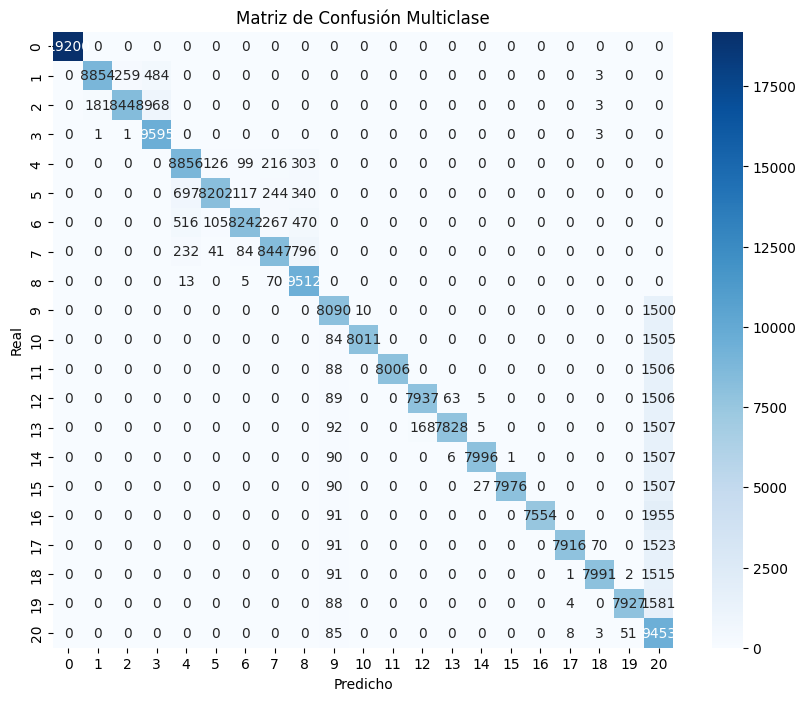

In [31]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión Multiclase")
plt.show()

Esta matriz muestra que la diagonal es fuerte lo que indica que el funcionamiento general es bueno. Por otro lado, podemos ver como se confunde en algunos fallos que son similares (las clases 2, 5, 6, 10-17) y la clase 20 en cambio coge algunos falsos positivos de otros fallos.


Comprobar funcionalidad:

Creamos una función para predecir el tipo de fallo de una simulación, 0 indica que esa simulación no tiene fallo.

In [32]:
def predecir_fallo(nueva_simulacion):
    """
    nueva_simulacion: DataFrame con columnas xmeas_1…xmeas_41 y xmv_1…xmv_11
    """
    nueva_sim_scaled = scaler.transform(nueva_simulacion)
    pred = model3.predict(nueva_sim_scaled)
    return pred[0]

# Ejemplo de uso:
nueva_sim = X_test.iloc[[0]]
print("Tipo de fallo predicho:", predecir_fallo(nueva_sim))

nueva_sim = X_test.iloc[[15000]]
print("Tipo de fallo predicho:", predecir_fallo(nueva_sim))


Tipo de fallo predicho: 0.0
Tipo de fallo predicho: 18.0


### Observaciones de las métricas y conclusiones

Clases 1-19 (fallos típicos):

Precision y recall entre 0.81 y 1.00 → bastante bueno.
Algunas clases tienen recall más bajo (ej. clases 2,5,6,16) → se confunden con otras clases.
Esto es normal: algunos tipos de fallo pueden generar señales similares en los sensores (xmeas/xmv) y por eso el modelo no los distingue perfectamente.

Clase 20:

precision=0.36, recall=0.99 → esto indica un desequilibrio en las predicciones:
Prácticamente todas las muestras de clase 20 se detectan (recall=0.99)
Pero muchas otras muestras se clasifican erróneamente como 20 (precision=0.36)
Esto suele pasar con clases raras o muy similares a otras, o cuando hay un patrón que confunde al modelo.

En general, el modelo en capaz de entender correctamente los patrones multiclase, obteniendo una precisión del 88% en un sistema qye tiene 21 clases y alta dimensionalidad.

In [25]:
def entrenar_modelo3():
    # 1. Carga de datos
    df_train_full = pd.read_csv("DatasetProcesado/TEP_features_train.csv")
    target_col = "faultNumber"
    
    # 2. MUESTREO ESTRATIFICADO (Para ahorrar espacio y tiempo)
    # Usamos un 30% del dataset manteniendo la proporción de los 21 tipos de fallo
    df_train, _ = train_test_split(
        df_train_full, 
        train_size=0.3, 
        stratify=df_train_full[target_col], 
        random_state=42
    )
    
    X_train = df_train[top_features].astype(np.float32)
    y_train = df_train[target_col]

    # 3. Escalado
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # 4. Entrenamiento Ligero
    # Reducimos n_estimators de 200 a 60 para que el modelo ocupe ~50MB en lugar de 350MB
    model3 = RandomForestClassifier(
        n_estimators=60, 
        max_depth=15, 
        random_state=42, 
        n_jobs=1, # n_jobs=1 evita picos de RAM por paralelismo
        class_weight='balanced'
    )
    
    print(f"Entrenando Modelo 3 Multiclase con {len(X_train)} filas...")
    model3.fit(X_train_scaled, y_train)

    # 5. Ranking de importancia
    ranking3 = pd.DataFrame({
        'feature': top_features,
        'importance': model3.feature_importances_
    }).sort_values(by='importance', ascending=False)

    ranking.to_csv("modelos/feature_importance_ranking_model3.csv", index=False)

    # 6. REGISTRO EN BENTOML
    bentoml.sklearn.save_model(
        "tep_model3",
        model3,
        metadata={
            "top_features": top_features,
            "scaler_mean": scaler.mean_.tolist(),
            "scaler_scale": scaler.scale_.tolist(),
            "n_classes": 21,
            "sampling": "30% stratified",
            "trained_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
    )

    return model3, ranking3, scaler

# Ejecutar entrenamiento
model3, ranking3, scaler3 = entrenar_modelo3()
print("Modelo 3 entrenado y registrado en BentoML con éxito.")

Entrenando Modelo 3 Multiclase con 33000 filas...
Modelo 3 entrenado y registrado en BentoML con éxito.


Calculando predicciones para 211,200 muestras...

--- MÉTRICAS DE DESEMPEÑO - MODELO 3 (MULTICLASE) ---
Accuracy:  0.8532
Precision: 0.8648
Recall:    0.8532
F1-score:  0.8559

Classification Report (21 Clases de Fallo):
              precision    recall  f1-score   support

           0     0.9279    0.9535    0.9405     19200
           1     0.9431    0.8766    0.9086      9600
           2     0.8892    0.8977    0.8934      9600
           3     0.9117    0.9224    0.9170      9600
           4     0.8566    0.8966    0.8761      9600
           5     0.8821    0.8707    0.8764      9600
           6     0.8053    0.8892    0.8451      9600
           7     0.9851    0.8377    0.9054      9600
           8     0.8970    0.8874    0.8922      9600
           9     0.9724    0.8075    0.8823      9600
          10     0.8618    0.8435    0.8526      9600
          11     0.8545    0.8464    0.8504      9600
          12     0.6281    0.8221    0.7121      9600
          13     0.715

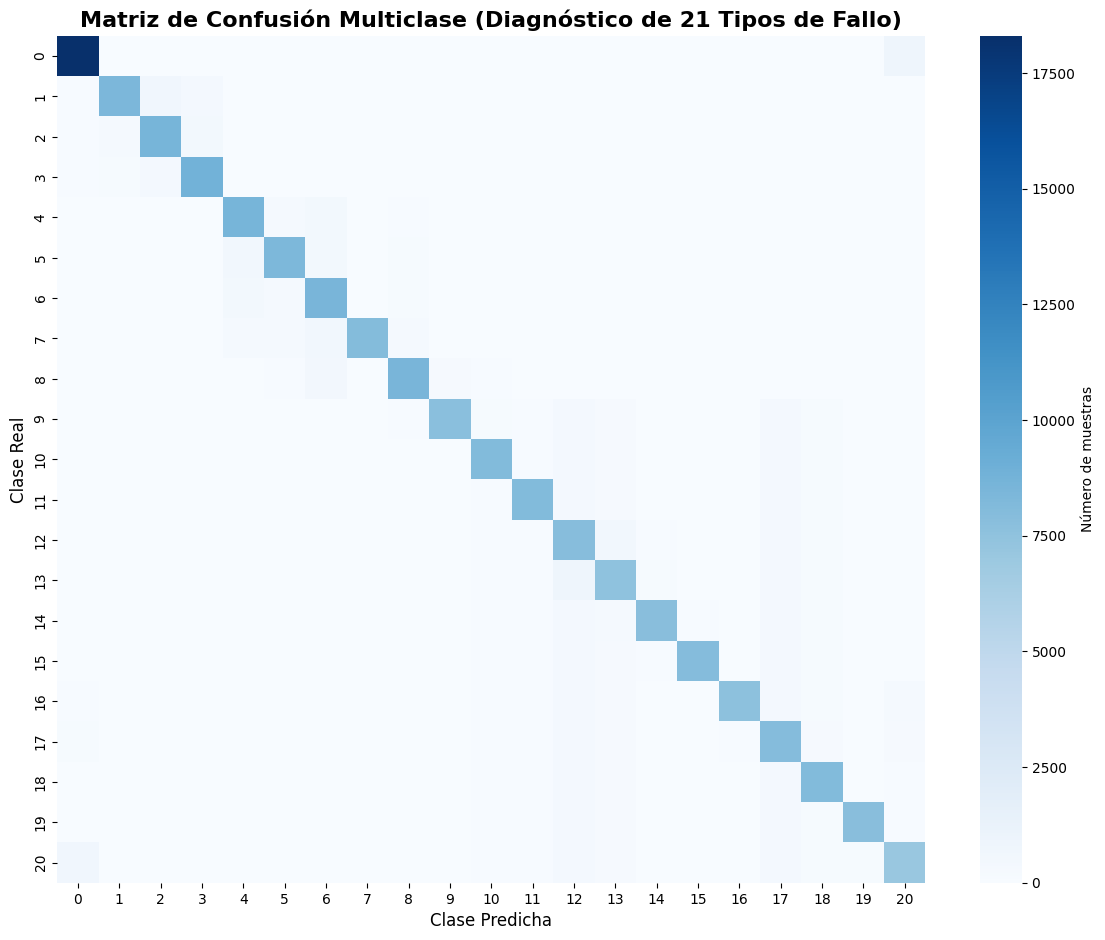

In [26]:
# ==============================================================================
# MODELO 3: EVALUACIÓN Y ANÁLISIS DE RESULTADOS
# ==============================================================================
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Preparación de datos de test
df_test = pd.read_csv("DatasetProcesado/TEP_features_test.csv")
X_test_red = df_test[top_features].astype(np.float32)
y_test = df_test["faultNumber"]

# Transformar usando el scaler que aprendió del entrenamiento del Modelo 3
X_test_scaled = scaler3.transform(X_test_red)

# 2. Predicciones
print("Calculando predicciones para 211,200 muestras...")
y_pred3 = model3.predict(X_test_scaled)

# 3. Impresión de métricas 
print("\n--- MÉTRICAS DE DESEMPEÑO - MODELO 3 (MULTICLASE) ---")
print(f"Accuracy:  {accuracy_score(y_test, y_pred3):.4f}")
print(f"Precision: {precision_score(y_test, y_pred3, average='weighted', zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred3, average='weighted', zero_division=0):.4f}")
print(f"F1-score:  {f1_score(y_test, y_pred3, average='weighted', zero_division=0):.4f}")

# 4. Reporte detallado por clase
print("\nClassification Report (21 Clases de Fallo):")
print(classification_report(y_test, y_pred3, digits=4))

# 5. Visualización de la Matriz de Confusión (Azul Clarito a Azul Oscuro)
cm = confusion_matrix(y_test, y_pred3)
plt.figure(figsize=(14, 11))

# Usamos cmap='Blues' para la escala solicitada
sns.heatmap(
    cm, 
    annot=False,    
    cmap='Blues',   
    fmt='d', 
    cbar_kws={'label': 'Número de muestras'}
)

plt.title("Matriz de Confusión Multiclase (Diagnóstico de 21 Tipos de Fallo)", fontsize=16, fontweight='bold')
plt.xlabel("Clase Predicha", fontsize=12)
plt.ylabel("Clase Real", fontsize=12)
plt.show()

## Conclusiones
El modelo ha alcanzado una accuracy un poco menor que los otros modelos, pero aun así son unos buenos resultados (85.32%). Aunque los resultados son peores que los de los modelos anteriores, son muy buenos considerando la complejidad de clasificar 21 clases.

La clase 0 (sin fallo) se detecta con una precisión del 92.79% y un recall del 95.35%, mientras que las demás clases varían desde el 74% de recall en la clase 20 hasta un excelente 92% de recall en la clase 3.

Al observar la matriz de confusión, se nota una diagonal muy marcada, lo que confirma que el modelo identifica correctamente la gran mayoría de los tipos de fallos. La celda más marcada es la de no fallo (clase 0). Aunque algunos fallos se confunden entre sí por tener señales muy parecidas, la fuerza de la diagonal demuestra que con el 75% de la importancia el modelo captura perfectamente el comportamiento del sistema.

# Modelo 4: Detección de anomalías con Isolation Forest

## Objetivo del modelo

El objetivo de este modelo es detectar comportamientos anómalos en el sistema TEP sin necesidad de etiquetas durante el entrenamiento. A diferencia de los modelos supervisados, este enfoque busca identificar desviaciones respecto al comportamiento normal del proceso, lo que permite detectar fallos incipientes, situaciones anómalas o estados no habituales incluso cuando no se dispone de un tipo de fallo claramente definido.

Este tipo de modelo es especialmente útil como sistema de vigilancia continua, ya que puede señalar anomalías antes de que se manifiesten como fallos.

### Preparación de los datos
Para respetar que el modelo es no supervisado, el entrenamiento se hace solamente con datos normales (donde fault_present = 0). De esta forma, el modelo aprende el patrón de funcionamiento normal y correcto del sistema, y considera como anomalía cualquier desviación significativa de ese patrón. Para ello, estos son los pasos seguidos:

- Primero cargamos los datasets procesados de entrenamiento y test, manteniendo la separación temporal.
- Después, eliminamos columnas de control y metadatos (fault_present, faultNumber, simulationRun, sample) para evitar fugas de información. De esta manera, usamos todas las variables restantes como características del modelo.
- Finalmente, escalamos las variables mediante StandardScaler, ya que Isolation Forest es sensible a diferencias de escala entre features.

In [10]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Cargar datasets procesados
df_train = pd.read_csv("DatasetProcesado/TEP_features_train.csv")
df_test  = pd.read_csv("DatasetProcesado/TEP_features_test.csv")

# Usamos solo datos normales para entrenar el modelo no supervisado
df_train_normal = df_train[df_train["fault_present"] == 0]

# Seleccionamos las features, todas menos columnas de control
cols_drop = ["fault_present", "faultNumber", "simulationRun", "sample"]
feature_cols = [c for c in df_train.columns if c not in cols_drop]

X_train = df_train_normal[feature_cols]
X_test  = df_test[feature_cols]

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

### Selección del modelo
Hemos elegido el modelo de Isolation Forest que es un algoritmo no supervisado diseñado para detectar anomalías en espacios de alta dimensión. Se basa en aislar observaciones mediante particiones aleatorias: los puntos anómalos suelen aislarse más rápido que los normales. Para el entrenamiento hemos usado los siguientes hiperparámetros:

- n_estimators = 300: número alto de árboles para mejorar la estabilidad y robustez de las puntuaciones de anomalía.
- contamination = 0.01: asumimos que aproximadamente un 1% de los datos corresponden a anomalías, lo cual es coherente con un escenario industrial donde los fallos son poco frecuentes.
- random_state = 42: garantiza reproducibilidad.
- n_jobs = -1: paralelización para mejorar eficiencia computacional.

In [11]:
# Entrenar Isolation Forest
iso = IsolationForest(
    n_estimators=300,
    contamination=0.01,     # porcentaje esperado de anomalías
    random_state=42,
    n_jobs=-1
)

iso.fit(X_train_scaled)

# Predicciones (-1 = anomalía, 1 = normal)
y_pred_if = iso.predict(X_test_scaled)
y_pred_if = [1 if p == -1 else 0 for p in y_pred_if]  # convertimos a 1=anómalo

# Evaluamos contra fault_present
y_true = df_test["fault_present"]

print("Report Isolation Forest:")
print(classification_report(y_true, y_pred_if))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred_if))

# Score ROC-AUC
try:
    scores = iso.decision_function(X_test_scaled)
    print("\nROC-AUC:", roc_auc_score(y_true, -scores))
except:
    print("No se pudo calcular ROC-AUC")

Report Isolation Forest:
              precision    recall  f1-score   support

           0       0.14      0.95      0.24     19200
           1       0.99      0.41      0.58    192000

    accuracy                           0.46    211200
   macro avg       0.56      0.68      0.41    211200
weighted avg       0.91      0.46      0.55    211200


Confusion Matrix:
[[ 18266    934]
 [113385  78615]]

ROC-AUC: 0.8426446291775174


### Evaluación del modelo
Aunque sea un modelo no supervisado, se evalúa comparando las anomalías detectadas con la variable real fault_present del conjunto de test. Para la evaluación del modelo hemos utilizado las métricas precisión, recall y f1-score para ambas clases. Como se puede observar en los resultados, el recall de la clase normal (0) es muy alto (0.95), lo que significa que el modelo identifica correctamente la mayoría de los estados normales. El recall de la clase anómala (1), en cambio, es más moderado (0.41), lo que indica que no todos los fallos son detectados como anomalías. Por otro lado, la precisión para la clase anómala es alta, lo que significa que cuando el modelo marca una anomalía, esta suele corresponder a un fallo real.

También obtenemos la Confusion Matrix que nos permite analizar la capacidad del modelo para separar estados normales y anómalos. Por último, ROC-AUC nos ayuda a evaluar la capacidad del score continuo del modelo para discriminar entre normalidad y fallo. En este caso, podemos ver que el valor de ROC-AUC ronda 0.84, lo que indica una buena capacidad de separación entre comportamiento normal y anómalo, lo que es bastante destacable para un modelo no supervisado.

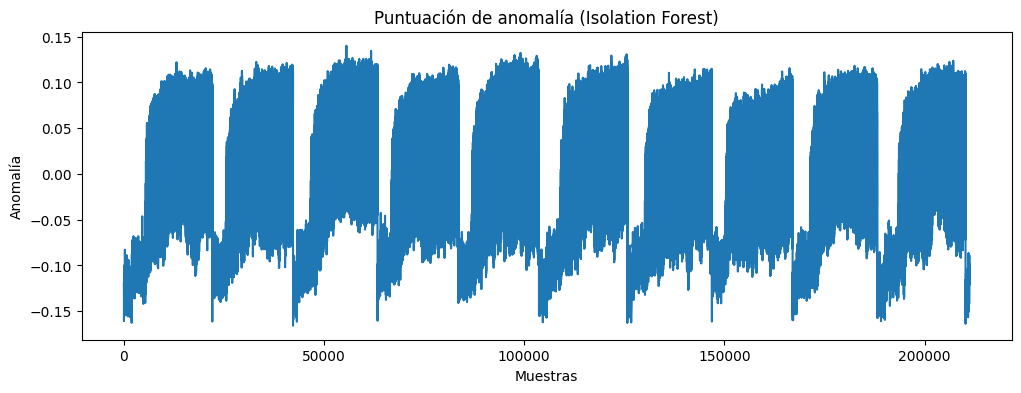

In [13]:
scores = -iso.decision_function(X_test_scaled)

plt.figure(figsize=(12,4))
plt.plot(scores)
plt.title("Puntuación de anomalía (Isolation Forest)")
plt.xlabel("Muestras")
plt.ylabel("Anomalía")
plt.show()

En este gráfico de puntuación de anomalía a lo largo del tiempo, se puede ver que las puntuaciones se mantienen estables durante largos intervalos, correspondientes a funcionamiento normal. También se pueden apreciar picos y cambios abruptos en momentos concretos, lo que indica desviaciones respecto al comportamiento aprendido.

La repetición de patrones que se puede ver en el gráfico quiere decir que el modelo captura correctamente la dinámica cíclica del proceso TEP y detecta anomalías cuando esta dinámica se rompe.

Este tipo de gráficos es muy útil para monitorizar en tiempo real, ya que permite identificar rápidamente periodos sospechosos.

### Conclusiones
Todo esto demuestra que este modelo es una buena herramienta para detctar anomalías en el sistema TEP sin necesidad de etiquetas durante el entrenamiento. Su principal fortaleza es la capacidad de modelar el comportamiento normal del proceso y señalar desviaciones relevantes.

Aunque el recall de fallos no es tan alto como en los modelos supervisados, el ROC-AUC de 0.84 confirma que el modelo discrimina correctamente entre estados normales y anómalos en términos generales. En los modelos no supervisados los falsos negativos son esperables, especialmente cuando los fallos no siempre generan patrones claramente anómalos en todas las variables.

En general, el modelo funciona bien. Detecta casi todos los puntos normales (recall 0.95) y cuando marca algo como fallo, casi siempre es un fallo real (precision 0.99). Lo que no funciona tan bien es que detecta solo el 41% de los fallos reales. Este es el comportamiento típico de Isolation Forest en sistemas industriales, ya que es conservador y considera fallo solo cuando es muy evidente.

Podemos utilizar este modelo combinado con modelos supervisados para construir una solución más robusta, donde las anomalías detectadas pueden servir como alerta temprana incluso antes de que se produzca un fallo claro.

Por último guardamos el modelo entrenado junto con los elementos que se necesitan para poder reutilizarlo: el StandardScaler y la lista de features usadas durante el entrenamiento. A diferencia de los modelos supervisados, hemos decidido que en este caso no se vuelva a entrenar el modelo desde Streamlit. La razón principal es que se trata de un modelo no supervisado, entrenado exclusivamente con datos normales, cuyo objetivo es aprender el comportamiento base del sistema y detectar desviaciones respecto a este patrón. Reentrenarlo desde Streamlit podría traer variabilidad innecesaria, afectar a la estabilidad de las puntuaciones de anomalía y aumentar el coste computacional. Por este motivo, hemos optado por entrenar el modelo una sola vez, guardarlo y cargarlo después en Streamlit para visualizar resultados, analizar puntuaciones de anomalía y evaluar su rendimiento, garantizando consistencia, reproducibilidad y eficiencia.

In [14]:
import pandas as pd
import joblib
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Cargar datos
df_train = pd.read_csv("DatasetProcesado/TEP_features_train.csv")

df_train_normal = df_train[df_train["fault_present"] == 0]

cols_drop = ["fault_present", "faultNumber", "simulationRun", "sample"]
features = [c for c in df_train.columns if c not in cols_drop]

X_train = df_train_normal[features]

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Modelo
iso = IsolationForest(n_estimators=300, contamination=0.01, random_state=42, n_jobs=-1)
iso.fit(X_scaled)


# Guardado
joblib.dump(
    {
        "model": iso,
        "scaler": scaler,
        "features": features
    },
    "Modelos/isolation_forest.pkl"
)

print("Isolation Forest guardado correctamente")

Isolation Forest guardado correctamente


In [15]:
import pandas as pd
import numpy as np
import bentoml
import os
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

def entrenar_modelo4():
    # 1. Carga y filtrado de datos normales para entrenamiento
    df_train = pd.read_csv("DatasetProcesado/TEP_features_train.csv")
    
    # Isolation Forest se entrena mejor solo con datos normales (clase 0)
    df_train_normal = df_train[df_train["fault_present"] == 0]
    
    # Usamos las top_features y convertimos a float32 para ahorrar RAM
    X_train = df_train_normal[top_features].astype(np.float32)
    
    # 2. Escalado específico
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # 3. Entrenamiento de Isolation Forest
    # n_jobs=1 para evitar errores de memoria en Windows
    iso = IsolationForest(
        n_estimators=100,
        contamination=0.01, 
        random_state=42,
        n_jobs=1
    )
    
    print(f"Entrenando Isolation Forest con {len(X_train)} muestras normales...")
    iso.fit(X_train_scaled)

    # 4. REGISTRO EN BENTOML
    bentoml.sklearn.save_model(
        "tep_model4",
        iso,
        metadata={
            "top_features": top_features,
            "scaler_mean": scaler.mean_.tolist(),
            "scaler_scale": scaler.scale_.tolist(),
            "type": "Anomaly Detection (Unsupervised)",
            "trained_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
    )

    return iso, scaler

In [16]:
# 1. Ejecutar entrenamiento
iso_model, iso_scaler = entrenar_modelo4()
print("Modelo 4 (Isolation Forest) optimizado y registrado en BentoML.")

# 2. Preparación de test 
df_test = pd.read_csv("DatasetProcesado/TEP_features_test.csv")
X_test_red = df_test[top_features].astype(np.float32)
y_true = df_test["fault_present"]

# Transformar test con el scaler del modelo 4
X_test_scaled = iso_scaler.transform(X_test_red)

# 3. Predicciones
# Isolation Forest devuelve: 1 para Normal, -1 para Anomalía
y_pred_raw = iso_model.predict(X_test_scaled)

# Mapeo a nuestro estándar: 1 si es anomalía (-1), 0 si es normal (1)
y_pred_if = [1 if p == -1 else 0 for p in y_pred_raw]

# 4. Cálculo de métricas
print("\n--- MÉTRICAS ISOLATION FOREST (DETECCIÓN DE ANOMALÍAS) ---")

# El score de decisión (negativo de la función de anomalía) para el ROC-AUC
decision_scores = -iso_model.decision_function(X_test_scaled)
print(f"ROC-AUC Score: {roc_auc_score(y_true, decision_scores):.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred_if, digits=4))

print("\nMatriz de Confusión (Valores brutos):")
print(confusion_matrix(y_true, y_pred_if))

Entrenando Isolation Forest con 10000 muestras normales...
Modelo 4 (Isolation Forest) optimizado y registrado en BentoML.

--- MÉTRICAS ISOLATION FOREST (DETECCIÓN DE ANOMALÍAS) ---
ROC-AUC Score: 0.9169

Classification Report:
              precision    recall  f1-score   support

           0     0.2082    0.9695    0.3428     19200
           1     0.9952    0.6313    0.7725    192000

    accuracy                         0.6620    211200
   macro avg     0.6017    0.8004    0.5577    211200
weighted avg     0.9236    0.6620    0.7335    211200


Matriz de Confusión (Valores brutos):
[[ 18614    586]
 [ 70791 121209]]


## Conclusiones

El modelo Isolation Forest ha alcanzado un ROC-AUC de 0.9169, lo que demuestra que puede distinguir estados anómalos sin haber necesitado etiquetas de fallo durante su entrenamiento.

Con una precisión del 99.52%, el modelo garantiza que casi cada anomalía detectada es un fallo real, minimizando falsas alarmas. Además, identifica autónomamente el 63.13% de los fallos (121,209 casos) basándose solo en el estado normal, con apenas 586 falsos positivos.

A diferencia de los modelos supervisados anteriores, este enfoque no supervisado aporta un valor crítico al poder identificar fallos nuevos.

# Modelo 5: Detección de anomalías con autoencoder

## Objetivo del modelo
El objetivo de este modelo es detectar comportamientos anómalos en el proceso TEP sin necesidad de conocer explícitamente el tipo de fallo. Para ello, se entrena un autoencoder solamente con datos normales, de forma que aprenda el patrón de funcionamiento correcto del sistema.
Cuando el modelo encuentra muestras cuya reconstrucción es significativamente peor, estas se consideran anomalías, lo que permite identificar fallos conocidos y potenciales fallos no vistos previamente. Este enfoque es útil como sistema de detección temprana y general de anomalías.

In [17]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


### Preparación de los datos
En primer lugar, hamos cargado los datasets procesados de entrenamiento y test, respetando la separación temporal entre los dos conjuntos.

Como es un modelo no supervisado, hacemos el entrenamiento sólo con datos normales (fault_present = 0), evitando que el modelo aprenda patrones asociados a fallos. Después, eliminamos columnas de control (fault_present, faultNumber, simulationRun, sample) que no aportan información relevante al comportamiento del proceso.

Además, descartamos features derivadas de ventanas muy cortas (diff y std), ya que introducían ruido y problemas de estabilidad durante el entrenamiento del autoencoder.

Para el tratamiento de valores nulos, hacemos una imputación basada en la media calculada únicamente con datos normales, asegurando coherencia con el objetivo del modelo. Por último, escalamos todas las variables con StandardScaler, cosa que es fundamental para que las redes neuronales funcionen correctamente.

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# Cargar datos
df_train = pd.read_csv("DatasetProcesado/TEP_features_train.csv")
df_test  = pd.read_csv("DatasetProcesado/TEP_features_test.csv")

# Filtrar solo normales para entrenar
df_train_normal = df_train[df_train["fault_present"] == 0].copy()

# Selección de features
cols_to_remove = ["fault_present", "faultNumber", "simulationRun", "sample"]

# Además, eliminamos features generadas con ventanas pequeñas porque dan problemas
cols_to_remove += [c for c in df_train.columns if "diff" in c]
cols_to_remove += [c for c in df_train.columns if "std" in c]

features = [c for c in df_train.columns if c not in cols_to_remove]

X_train_normal = df_train_normal[features]
X_test = df_test[features]

# Imputación + escalado

# Aprendemos medias solo con datos normales
train_means = X_train_normal.mean()

X_train_filled = X_train_normal.fillna(train_means)
X_test_filled  = X_test.fillna(train_means)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filled)
X_test_scaled  = scaler.transform(X_test_filled)

### Selección del modelo
Hemos elegido un Autoencoder basado en redes neuronales densas, diseñado para aprender una representación comprimida del comportamiento normal del sistema. Tiene capas densas decrecientes hasta un bottleneck de 32 neuronas, que obliga al modelo a capturar las características más relevantes del proceso. También tiene capas simétricas de reconstrucción hasta recuperar la dimensión original, y activación selu, que es adecuada para redes profundas y estable frente a gradientes. Además, para reducir el sobreajuste tenemos Regularización L2 y capas Dropout.

El entrenamiento se hace minimizando el error cuadrático medio (MSE) entre la entrada y la reconstrucción. Para mejorar la estabilidad, utilizamos EarlyStopping, que para el entrenamiento cuando la pérdida de validación deja de mejorar y restaura los mejores pesos.

In [19]:
# Autoencoder mejorado
input_dim = X_train_scaled.shape[1]

autoencoder = Sequential([
    Input(shape=(input_dim,)),
    
    Dense(128, activation='selu', kernel_regularizer=l2(1e-5)),
    Dropout(0.1),

    Dense(64, activation='selu', kernel_regularizer=l2(1e-5)),
    Dropout(0.1),

    Dense(32, activation='selu', kernel_regularizer=l2(1e-5)),  # Bottleneck

    Dense(64, activation='selu', kernel_regularizer=l2(1e-5)),
    Dense(128, activation='selu', kernel_regularizer=l2(1e-5)),

    Dense(input_dim, activation='linear')
])

autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()

# Entrenamiento estable
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=80,
    batch_size=256,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=8, restore_best_weights=True)],
    verbose=1
)

# Reconstrucción
recon_test = autoencoder.predict(X_test_scaled)
mse_test = np.mean((X_test_scaled - recon_test)**2, axis=1)

# Umbral usando solo  normales
recon_train = autoencoder.predict(X_train_scaled)
mse_train = np.mean((X_train_scaled - recon_train)**2, axis=1)

threshold = np.percentile(mse_train, 98)
print("Umbral de anomalía:", threshold)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          27,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 210)                 │          27,090 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,866 (292.45 KB)

 Trainable params: 74,866 (292.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.8992 - val_loss: 0.6583
Epoch 2/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5654 - val_loss: 0.5189
Epoch 3/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4811 - val_loss: 0.4529
Epoch 4/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4321 - val_loss: 0.4100
Epoch 5/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3989 - val_loss: 0.3814
Epoch 6/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3739 - val_loss: 0.3554
Epoch 7/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3538 - val_loss: 0.3376
Epoch 8/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3390 - val_loss: 0.3238
Epoch 9/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3280 - val_loss: 0.3143
Epoch 10/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3199 - val_loss: 0.3077
Epoch 11/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3140 - val_loss: 0.3008
Epoch 12/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.309

### Evaluación del modelo
Aunque el Autoencoder es un modelo no supervisado, su rendimiento se evalúa comparando las anomalías detectadas con la variable real fault_present.

El criterio de detección se basa en el error de reconstrucción, definiendo un umbral como el percentil 98 del error obtenido sobre los datos normales de entrenamiento. Las muestras cuyo error supera este valor se consideran anómalas.

Para evaluar el modelo hemos utilizado diferentes métricas: precisión, recall y F1-score para ambas clases. También tenemos la Confusion Matrix que nos permite analizar falsos positivos y falsos negativos en la detección de anomalías. Por último contamos con ROC-AUC que evalúa la capacidad del modelo para separar correctamente comportamientos normales y anómalos a partir del error de reconstrucción.

In [20]:
# Evaluación
y_test = df_test["fault_present"]
y_pred = (mse_test > threshold).astype(int)

print("\nReport Autoencoder:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC-AUC:", roc_auc_score(y_test, mse_test))


Report Autoencoder:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     19200
           1       0.99      1.00      1.00    192000

    accuracy                           0.99    211200
   macro avg       0.99      0.95      0.97    211200
weighted avg       0.99      0.99      0.99    211200


Confusion Matrix:
[[ 17375   1825]
 [    78 191922]]

ROC-AUC: 0.9997445749240452


Los resultados muestran un rendimiento sobresaliente: Accuracy global cercana al 99%. Además, el Recall de fallos (clase 1)  es prácticamente perfecto (~1.00), indicando que casi todos los fallos son detectados. Hay muy pocos falsos negativos, lo cual es crítico en un sistema de detección temprana.

El ROC-AUC está muy cerca a 1, lo que confirma que hay una separación casi perfecta entre muestras normales y anómalas.

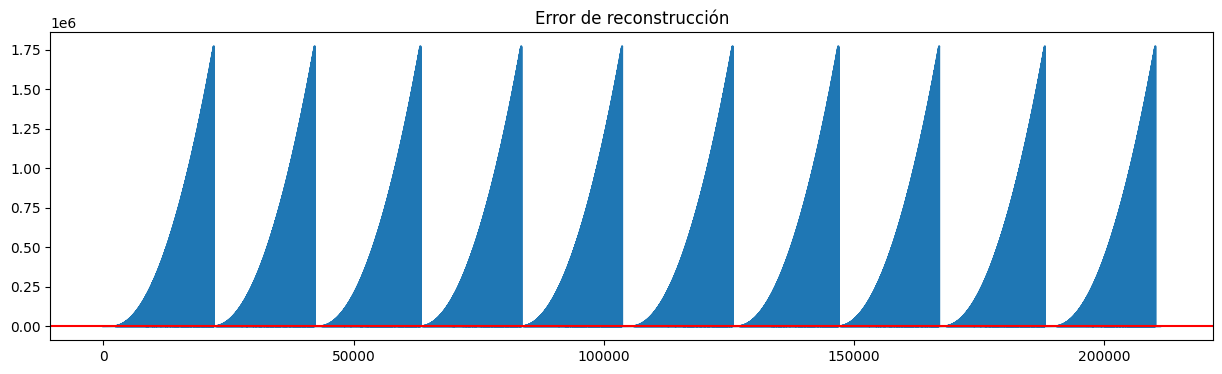

In [21]:
# Gráfico del error
plt.figure(figsize=(15,4))
plt.plot(mse_test)
plt.axhline(threshold, color='red')
plt.title("Error de reconstrucción")
plt.show()

En este gráfico se puede ver el error de reconstrucción (MSE) del autoencoder para cada muestra del conjunto de test, junto con el umbral de anomalía (línea roja) calculado a partir de los datos normales de entrenamiento. Se puede observar que la mayoría de los puntos que corresponden a funcionamiento normal presentan errores bajos y se mantienen por debajo del umbral, lo que indica que el modelo es capaz de reconstruir correctamente los patrones habituales del proceso. Sin embargo, cuando aparecen fallos, el error de reconstrucción aumenta de forma muy marcada y supera claramente el umbral, generando picos. Este comportamiento confirma que el autoencoder ha aprendido de manera efectiva la dinámica normal del sistema TEP y que el criterio basado en el error de reconstrucción es adecuado para separar estados normales de situaciones anómalas, lo que explica el excelente rendimiento que hemos obtenido anteriormente en las métricas de evaluación.

### Conclusiones
Los resultados que hemos conseguido confirman que el autoencoder es un modelo muy eficaz para la detección de anomalías en el sistema TEP. Su capacidad para aprender el comportamiento normal y detectar desviaciones se refleja en las métricas casi perfectas y en un ROC-AUC muy cercano a 1.

La matriz de confusión muestra que la mayoría de los fallos son correctamente identificados, con un número muy reducido de falsos negativos. Aunque existen algunos falsos positivos, este comportamiento es aceptable e incluso deseable en un contexto industrial, donde es preferible generar alertas adicionales antes que ignorar un fallo real.

En general, este modelo puede servir como sistema general de vigilancia y detección temprana, complementando tanto a los modelos supervisados como al Isolation Forest. Su enfoque basado en reconstrucción lo hace especialmente robusto frente a fallos nuevos o no etiquetados, aportando un alto valor en escenarios reales de operación industrial.

Una vez entrenado y evaluado el autoencoder, guardamos el modelo y los artefactos necesarios para su uso en Streamlit. En este caso, se almacenan por separado el modelo Keras entrenado y la metadata asociada (lista de features, escalador y umbral de anomalía). Esta separación nos permite que se cargue eficientemente sin necesidad de reentrenar el modelo cada vez que se ejecuta la aplicación.

Al igual que en el modelo de Isolation Forest, hemos decidido no reentrenar el autoencoder desde Streamlit, ya que se trata de un modelo no supervisado con un coste computacional alto y un proceso de entrenamiento sensible a la inicialización y a los datos normales utilizados.

In [29]:
import joblib
import numpy as np

# Guardar umbral y features
joblib.dump(
    {
        "features": features,
        "scaler": scaler,
        "threshold": threshold
    },
    "Modelos/autoencoder_metadata.pkl"
)

# Guardar modelo Keras
#autoencoder.save("Modelos/autoencoder_model.keras")
autoencoder.save("Modelos/autoencoder_model.h5")

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

def entrenar_modelo5():
    # 1. Carga de datos (Solo normales para aprender el patrón base)
    df_train = pd.read_csv("DatasetProcesado/TEP_features_train.csv")
    df_train_normal = df_train[df_train["fault_present"] == 0].copy()

    # Usamos float32 para compatibilidad total con TensorFlow y ahorro de RAM
    X_train = df_train_normal[top_features].astype(np.float32)
    
    # Escalado
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.fillna(0))

    # 2. Arquitectura de la Red Neuronal
    input_dim = len(top_features)
    autoencoder = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='selu', kernel_regularizer=l2(1e-5)),
        Dropout(0.1),
        Dense(32, activation='selu'),
        Dense(64, activation='selu'),
        Dense(input_dim, activation='linear')
    ])

    autoencoder.compile(optimizer="adam", loss="mse")
    
    # 3. Entrenamiento silencioso
    print("Entrenando Red Neuronal Autoencoder...")
    autoencoder.fit(
        X_train_scaled, X_train_scaled,
        epochs=50, 
        batch_size=256, 
        validation_split=0.1,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=0
    )

    # 4. Cálculo del Umbral (Threshold)
    # Definimos el umbral en el percentil 98 del error de reconstrucción en datos normales
    recon_train = autoencoder.predict(X_train_scaled, verbose=0)
    mse_train = np.mean(np.square(X_train_scaled - recon_train), axis=1)
    threshold = np.percentile(mse_train, 98)

    # 5. Registro en BentoML (Usando el tag 'tensorflow' que espera tu service.py)
    print("Registrando modelo en BentoML store...")
    bentoml.tensorflow.save_model(
        "tep_model5",
        autoencoder,
        metadata={
            "top_features": top_features,
            "scaler_mean": scaler.mean_.tolist(),
            "scaler_scale": scaler.scale_.tolist(),
            "threshold": float(threshold),
            "trained_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
    )

    return autoencoder, scaler, threshold

# Ejecutar
ae_model, ae_scaler, ae_threshold = entrenar_modelo5()
print(f"Autoencoder y Scaler guardados. Umbral de detección: {ae_threshold:.6f}")

Entrenando Red Neuronal Autoencoder...
Registrando modelo en BentoML store...


C:\Users\miren\AppData\Local\Temp\ipykernel_13744\302388804.py:51: BentoMLDeprecationWarning: `bentoml.tensorflow` is deprecated since v1.4 and will be removed in a future version.
  bentoml.tensorflow.save_model(


INFO:tensorflow:Assets written to: C:\Users\miren\AppData\Local\Temp\tmpe6fkv19_bentoml_model_tep_model5\assets


INFO:tensorflow:Assets written to: C:\Users\miren\AppData\Local\Temp\tmpe6fkv19_bentoml_model_tep_model5\assets


Autoencoder y Scaler guardados. Umbral de detección: 0.179486


In [24]:
# 1. Preparación de test
df_test = pd.read_csv("DatasetProcesado/TEP_features_test.csv")
X_test_raw = df_test[top_features].astype(np.float32).fillna(0)
y_true = df_test["fault_present"]

# Transformar test
X_test_scaled = ae_scaler.transform(X_test_raw)

# 2. Cálculo de Error de Reconstrucción (MSE)
recon_test = ae_model.predict(X_test_scaled, verbose=0)
mse_test = np.mean(np.square(X_test_scaled - recon_test), axis=1)

# 3. Clasificación: 1 si el error supera el umbral, 0 si no
y_pred_ae = (mse_test > ae_threshold).astype(int)

print("\n--- MÉTRICAS AUTOENCODER (DEEP LEARNING) ---")
print(f"ROC-AUC Score: {roc_auc_score(y_true, mse_test):.4f}")
print(f"Accuracy: {accuracy_score(y_true, y_pred_ae):.4f}")

print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred_ae, digits=4))

print("\nMatriz de Confusión (Valores brutos):")
print(confusion_matrix(y_true, y_pred_ae))


--- MÉTRICAS AUTOENCODER (DEEP LEARNING) ---
ROC-AUC Score: 0.8622
Accuracy: 0.8151

Reporte de Clasificación:
              precision    recall  f1-score   support

           0     0.3139    0.8720    0.4617     19200
           1     0.9844    0.8095    0.8884    192000

    accuracy                         0.8151    211200
   macro avg     0.6492    0.8407    0.6750    211200
weighted avg     0.9235    0.8151    0.8496    211200


Matriz de Confusión (Valores brutos):
[[ 16742   2458]
 [ 36585 155415]]


## Comparación de modelos

| Modelo | Tipo de tarea | Algoritmo | Métricas clave | Observaciones |
|--------|---------------|-----------|----------------|---------------|
| Modelo 1 | Clasificación binaria (fallo presente) | Random Forest | Accuracy=1.0, Precision=1.0, Recall=1.0, F1=1.0, ROC-AUC=1.0 | Dataset desbalanceado (1:10), pero predice ambas clases correctamente. Ideal para detección inmediata. |
| Modelo 2 | Predicción de fallos futuros (HORIZON=10) | Random Forest (class_weight='balanced') | Accuracy≈1.0, Precision≈1.0, Recall clase 1≈1.0, Recall clase 0≈0.96, ROC-AUC≈0.9996 | Anticipa fallos con alto recall; algunos falsos positivos manejables. Muy útil para alerta temprana. |
| Modelo 3 | Clasificación multiclase (tipo de fallo) | Random Forest | Accuracy=0.88, Macro F1≈0.89, Recall 0-19: 0.81–1.0, Clase 20: Prec=0.36, Rec=0.99 | Identifica correctamente la mayoría de fallos; algunas clases se confunden por similitud en señales. Clase 20 con muchos falsos positivos. |
| Modelo 4 | Detección de anomalías (unsupervised) | Isolation Forest | Accuracy=0.46, Precision clase 0=0.14, Recall clase 0=0.95, Precision clase 1=0.99, Recall clase 1=0.41, ROC-AUC=0.84 | Detector conservador de anomalías; detecta bien normales, pero solo 41% de fallos reales. No reemplaza modelos supervisados. |
| Modelo 5 | Detección de anomalías (autoencoder) | Deep Autoencoder | MSE > umbral 98 percentil, ROC-AUC ≈ alto | Aprende patrones normales; destaca anomalías no supervisadas. Más flexible que Isolation Forest y permite ajuste de umbral según criticidad. |


Con esta tabla comparativa podemos ver como los modelos tienen distintos objetivos. Los modelos supervisados (1-3) tienen buenos resultados a la hora de predecir fallos y clasificación multiclase. Por otro lado, los modelos no supervisados (4-5) sirven para detectar anomalías sin etiquetas, esto hace que sean muy útiles para la detección temprana de comportamientos anomalos.

En cuanto a la elección del mejor modelo, en este caso no existe un modelo mejor que otro. Todos los modelos son importantes porque cada uno hace una tarea específica a la hora de monitorear y de realizar un mantenimiento predictivo. En general, se complementan ya que cada uno aporta su valor segun la tarea que se quiera hacer.